# Price Band Mechanism Analysis

This notebook develops and calibrates dynamic Price Bands to detect Mark-Book price deviations. We implement two approaches:

1. **Simple Model**: Fixed bandwidth bands (Paradex/GRVT style) with symmetric upper and lower bounds
2. **Complex Model**: Dynamic EWMA volatility-based bands that adapt to market conditions

For each model, we use historical data to regress optimal parameters that balance false positive and false negative rates.

**Data Source**: Extended dataset from 2025-01-01 to latest available date

## 1. Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mstats
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 6)
pd.set_option('display.float_format', lambda x: f'{x:.6f}')

### Data Loading Functions

We load the same three data sources from the extended dataset (2025-01-01 to latest):
- **Mark Price**: Fair value used for liquidations and PnL
- **Index Price**: External spot market composite
- **Last Price (Trades)**: Actual trade executions with volume data

In [ ]:
# Define symbols to analyze (all available symbols in extended data)
SYMBOLS = ['BNB-USD', 'BTC-USD', 'DOGE-USD', 'ETH-USD', 'HYPE-USD', 'SOL-USD', 'SUI-USD']

# Data paths (using extended dataset)
DATA_DIR = Path('../../data/extended')
MARK_PRICE_DIR = DATA_DIR / 'mark_price'
INDEX_PRICE_DIR = DATA_DIR / 'index_price'
TRADES_DIR = DATA_DIR / 'trades'  # trades instead of klines for extended data

# Date range filter
START_DATE = '2025-01-01'
END_DATE = None  # None means use latest available date

def load_price_data(symbol: str, price_type: str = 'mark') -> pd.DataFrame:
    """
    Load OHLC price data for a given symbol.
    
    Args:
        symbol: Trading pair symbol (e.g., 'BTC-USD')
        price_type: Type of price data ('mark', 'index', or 'trades')
    
    Returns:
        DataFrame with OHLC data indexed by timestamp, filtered from START_DATE onwards
    """
    if price_type == 'mark':
        file_path = MARK_PRICE_DIR / f"{symbol}_1m.csv"
    elif price_type == 'index':
        file_path = INDEX_PRICE_DIR / f"{symbol}_1m.csv"
    elif price_type == 'trades':
        file_path = TRADES_DIR / f"{symbol}_1m.csv"
    else:
        raise ValueError(f"Unknown price_type: {price_type}")
    
    if not file_path.exists():
        print(f"Warning: {file_path} not found")
        return pd.DataFrame()
    
    df = pd.read_csv(file_path)
    df['open_time'] = pd.to_datetime(df['open_time'])
    df = df.set_index('open_time')
    
    # Ensure numeric columns
    for col in ['open', 'high', 'low', 'close']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    if 'volume' in df.columns:
        df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
    
    # Filter by date range
    if START_DATE is not None:
        df = df[df.index >= START_DATE]
    if END_DATE is not None:
        df = df[df.index <= END_DATE]
    
    return df

def load_all_symbols(price_type: str = 'mark') -> dict:
    """
    Load data for all symbols.
    
    Returns:
        Dictionary mapping symbol to DataFrame
    """
    data = {}
    for symbol in SYMBOLS:
        df = load_price_data(symbol, price_type)
        if not df.empty:
            data[symbol] = df
            print(f"Loaded {symbol} {price_type}: {len(df):,} records from {df.index[0]} to {df.index[-1]}")
    return data

In [3]:
# Load all three price types from extended data (2025-01-01 onwards)
print(f"Loading data from {START_DATE} to latest...")
print("\nLoading Mark Price data...")
mark_data = load_all_symbols('mark')

print("\nLoading Index Price data...")
index_data = load_all_symbols('index')

print("\nLoading Last Price (Trades) data...")
trades_data = load_all_symbols('trades')

print(f"\nSuccessfully loaded data for {len(mark_data)} symbols")

Loading data from 2025-01-01 to latest...

Loading Mark Price data...
Loaded BTC-USD mark: 584,640 records from 2025-01-01 00:00:00+00:00 to 2026-02-10 23:59:00+00:00
Loaded ETH-USD mark: 584,640 records from 2025-01-01 00:00:00+00:00 to 2026-02-10 23:59:00+00:00
Loaded SUI-USD mark: 584,640 records from 2025-01-01 00:00:00+00:00 to 2026-02-10 23:59:00+00:00
Loaded DOGE-USD mark: 584,640 records from 2025-01-01 00:00:00+00:00 to 2026-02-10 23:59:00+00:00
Loaded SOL-USD mark: 584,640 records from 2025-01-01 00:00:00+00:00 to 2026-02-10 23:59:00+00:00

Loading Index Price data...
Loaded BTC-USD index: 584,640 records from 2025-01-01 00:00:00+00:00 to 2026-02-10 23:59:00+00:00
Loaded ETH-USD index: 584,640 records from 2025-01-01 00:00:00+00:00 to 2026-02-10 23:59:00+00:00
Loaded SUI-USD index: 584,640 records from 2025-01-01 00:00:00+00:00 to 2026-02-10 23:59:00+00:00
Loaded DOGE-USD index: 584,640 records from 2025-01-01 00:00:00+00:00 to 2026-02-10 23:59:00+00:00
Loaded SOL-USD index: 

## 2. Price Deviation Metrics and Analysis

### The Mark-Book Deviation Problem

The Price Band mechanism addresses Oracle risk: when Mark Price (used for PnL and liquidations) diverges too far from Book Price (where trades execute), traders face execution risk. They might be liquidated based on Mark Price while the actual market price is far away, or execute trades at prices showing immediate large unrealized losses.

### Percentage Deviation

The fundamental metric is the percentage deviation between Mark Price and Last Price:

$$\text{Deviation}_t = \frac{\text{MarkPrice}_t - \text{LastPrice}_t}{\text{LastPrice}_t} \times 100$$

**Interpretation**:
- Positive deviation: Mark Price above Last Price
- Negative deviation: Mark Price below Last Price
- Normal conditions: typically within ±0.5% for liquid assets (BTC, ETH)
- Warning threshold: ±2% for less liquid assets

We also calculate Index-Last deviation to isolate spot-derivative basis from funding components:

$$\text{IndexDeviation}_t = \frac{\text{IndexPrice}_t - \text{LastPrice}_t}{\text{LastPrice}_t} \times 100$$

In [4]:
def calculate_price_deviations(symbol: str) -> pd.DataFrame:
    """
    Calculate price deviations between Mark, Index, and Last prices.
    
    Args:
        symbol: Trading pair symbol
    
    Returns:
        DataFrame with aligned prices and deviation metrics
    """
    # Get the three price types
    mark_df = mark_data.get(symbol)
    index_df = index_data.get(symbol)
    last_df = trades_data.get(symbol)  # Changed from klines_data to trades_data
    
    if mark_df is None or index_df is None or last_df is None:
        print(f"Missing data for {symbol}")
        return pd.DataFrame()
    
    # Align on common timestamps
    result = pd.DataFrame(index=last_df.index)
    result['last_price'] = last_df['close']
    result['mark_price'] = mark_df['close'].reindex(result.index, method='ffill')
    result['index_price'] = index_df['close'].reindex(result.index, method='ffill')
    
    # Calculate deviations (in percentage)
    result['mark_last_deviation'] = ((result['mark_price'] - result['last_price']) / result['last_price']) * 100
    result['index_last_deviation'] = ((result['index_price'] - result['last_price']) / result['last_price']) * 100
    result['mark_index_deviation'] = ((result['mark_price'] - result['index_price']) / result['index_price']) * 100
    
    # Add volume for context
    if 'volume' in last_df.columns:
        result['volume'] = last_df['volume']
    
    return result

In [5]:
# Calculate price deviations for all symbols
deviation_results = {}

print("Calculating price deviations for all symbols...\n")

for symbol in SYMBOLS:
    dev_df = calculate_price_deviations(symbol)
    if not dev_df.empty:
        deviation_results[symbol] = dev_df
        
        # Summary statistics
        print(f"{symbol}:")
        print(f"  Mark-Last Deviation - Mean: {dev_df['mark_last_deviation'].mean():.4f}%, Std: {dev_df['mark_last_deviation'].std():.4f}%")
        print(f"  Mark-Last Deviation - P95: {dev_df['mark_last_deviation'].abs().quantile(0.95):.4f}%, P99: {dev_df['mark_last_deviation'].abs().quantile(0.99):.4f}%")
        print(f"  Index-Last Deviation - Mean: {dev_df['index_last_deviation'].mean():.4f}%, Std: {dev_df['index_last_deviation'].std():.4f}%")
        print()

print(f"Completed deviation calculation for {len(deviation_results)} symbols")

Calculating price deviations for all symbols...

BTC-USD:
  Mark-Last Deviation - Mean: -0.0459%, Std: 0.1221%
  Mark-Last Deviation - P95: 0.2229%, P99: 0.4057%
  Index-Last Deviation - Mean: -0.0106%, Std: 0.1200%

ETH-USD:
  Mark-Last Deviation - Mean: -0.0688%, Std: 0.3047%
  Mark-Last Deviation - P95: 0.3175%, P99: 0.5719%
  Index-Last Deviation - Mean: -0.0262%, Std: 0.3009%

SUI-USD:
  Mark-Last Deviation - Mean: -0.0438%, Std: 0.5759%
  Mark-Last Deviation - P95: 1.0480%, P99: 1.9446%
  Index-Last Deviation - Mean: 0.0007%, Std: 0.5686%

DOGE-USD:
  Mark-Last Deviation - Mean: -0.0373%, Std: 0.4417%
  Mark-Last Deviation - P95: 0.8368%, P99: 1.5158%
  Index-Last Deviation - Mean: 0.0071%, Std: 0.4435%

SOL-USD:
  Mark-Last Deviation - Mean: -0.0429%, Std: 0.2722%
  Mark-Last Deviation - P95: 0.5670%, P99: 1.0775%
  Index-Last Deviation - Mean: 0.0063%, Std: 0.2742%

Completed deviation calculation for 5 symbols


### Top 10 Deviation Events per Symbol

In [6]:
from IPython.display import HTML, display

# Display top 10 deviation events for each symbol
display(HTML('<h3 style="text-align: center; margin-top: 20px; margin-bottom: 10px; font-weight: bold;">TOP 10 MARK-LAST PRICE DEVIATION EVENTS PER SYMBOL</h3>'))

for symbol in SYMBOLS:
    if symbol not in deviation_results:
        continue

    df = deviation_results[symbol].copy()

    # Get top 10 by absolute deviation
    df['abs_deviation'] = df['mark_last_deviation'].abs()
    top_10 = df.nlargest(10, 'abs_deviation')

    # Create display dataframe
    display_df = pd.DataFrame({
        'Timestamp': top_10.index.strftime('%Y-%m-%d %H:%M:%S'),
        'Mark Price': top_10['mark_price'],
        'Last Price': top_10['last_price'],
        'Index Price': top_10['index_price'],
        'Deviation (%)': top_10['mark_last_deviation'],
        'Abs Deviation (%)': top_10['abs_deviation']
    })

    display(HTML(f'<h4 style="text-align: center; margin-top: 15px; margin-bottom: 5px; font-weight: bold;">{symbol} - Top 10 Largest Deviations</h4>'))
    display(display_df.style.format({
        'Mark Price': '{:.6f}',
        'Last Price': '{:.6f}',
        'Index Price': '{:.6f}',
        'Deviation (%)': '{:.6f}',
        'Abs Deviation (%)': '{:.6f}'
    }).hide(axis='index'))


Timestamp,Mark Price,Last Price,Index Price,Deviation (%),Abs Deviation (%)
2025-02-03 02:07:00,91253.835361,96612.200000,91210.576805,-5.546261,5.546261
2025-02-03 01:55:00,91898.274668,96612.200000,91991.035000,-4.879224,4.879224
2025-02-03 02:06:00,92351.992115,96612.200000,92275.545411,-4.409596,4.409596
2025-02-03 01:54:00,92447.256294,96612.200000,92672.250000,-4.310991,4.310991
2025-02-03 02:08:00,92467.824241,96612.200000,92457.939983,-4.289702,4.289702
2025-02-03 04:59:00,92769.438296,96612.200000,92822.974225,-3.977512,3.977512
2025-02-03 02:09:00,92813.020497,96612.200000,93027.675358,-3.932401,3.932401
2025-02-03 05:10:00,92814.129408,96612.200000,92838.591144,-3.931254,3.931254
2025-02-03 05:11:00,92816.720685,96612.200000,92843.581022,-3.928571,3.928571
2025-02-03 05:09:00,92828.968751,96612.200000,92870.227049,-3.915894,3.915894


Timestamp,Mark Price,Last Price,Index Price,Deviation (%),Abs Deviation (%)
2025-02-03 02:07:00,2127.196358,2835.570000,2176.125324,-24.981702,24.981702
2025-02-03 02:08:00,2265.461469,2835.570000,2283.772909,-20.105606,20.105606
2025-02-03 02:09:00,2324.630592,2835.570000,2333.112113,-18.018931,18.018931
2025-02-03 02:10:00,2363.829325,2835.570000,2363.235825,-16.636538,16.636538
2025-02-03 02:11:00,2374.123045,2835.570000,2376.005925,-16.273517,16.273517
2025-02-03 01:55:00,2388.876088,2835.570000,2415.750000,-15.753232,15.753232
2025-02-03 02:06:00,2402.570720,2835.570000,2411.529904,-15.270273,15.270273
2025-02-03 02:13:00,2430.675451,2835.570000,2433.826572,-14.279124,14.279124
2025-02-03 02:12:00,2433.919882,2835.570000,2436.352226,-14.164705,14.164705
2025-02-03 02:14:00,2437.733219,2835.570000,2449.534748,-14.030223,14.030223


Timestamp,Mark Price,Last Price,Index Price,Deviation (%),Abs Deviation (%)
2025-10-10 21:22:00,1.357606,0.788200,1.168982,72.241248,72.241248
2025-10-10 21:33:00,2.363935,1.533700,2.315255,54.132823,54.132823
2025-10-10 21:34:00,2.205940,1.533700,2.192452,43.831266,43.831266
2025-10-10 21:32:00,2.177779,1.533700,2.147761,41.995141,41.995141
2025-10-10 21:40:00,2.166435,1.533700,2.165482,41.255469,41.255469
2025-10-10 21:35:00,2.138574,1.533700,2.124557,39.438873,39.438873
2025-10-10 21:31:00,2.098754,1.533700,2.056946,36.842533,36.842533
2025-10-10 21:39:00,2.092347,1.533700,2.087668,36.424784,36.424784
2025-10-10 21:37:00,2.083909,1.533700,2.076286,35.874595,35.874595
2025-10-10 21:21:00,1.070280,0.788200,1.012621,35.787811,35.787811


Timestamp,Mark Price,Last Price,Index Price,Deviation (%),Abs Deviation (%)
2025-10-10 21:22:00,0.129938,0.093470,0.131649,39.016138,39.016138
2025-10-10 21:35:00,0.171705,0.134350,0.172207,27.803871,27.803871
2025-10-10 21:21:00,0.119024,0.093470,0.119634,27.339769,27.339769
2025-10-10 21:30:00,0.169880,0.134350,0.169654,26.445626,26.445626
2025-10-10 21:40:00,0.169591,0.134350,0.168948,26.230984,26.230984
2025-10-10 21:36:00,0.168319,0.134350,0.167507,25.284128,25.284128
2025-10-10 21:37:00,0.167926,0.134350,0.168845,24.991759,24.991759
2025-10-10 21:38:00,0.166077,0.134350,0.166006,23.615000,23.615000
2025-10-10 21:34:00,0.166028,0.134350,0.166443,23.579046,23.579046
2025-10-10 21:29:00,0.165579,0.134350,0.167029,23.244250,23.244250


Timestamp,Mark Price,Last Price,Index Price,Deviation (%),Abs Deviation (%)
2025-02-03 02:07:00,176.043078,196.320000,176.825281,-10.328505,10.328505
2025-02-03 01:55:00,177.264612,196.320000,177.689729,-9.706290,9.706290
2025-02-03 02:08:00,178.907884,196.320000,178.905525,-8.869252,8.869252
2025-02-03 01:54:00,180.990132,196.320000,181.295055,-7.808613,7.808613
2025-02-03 02:09:00,181.307014,196.320000,181.526913,-7.647201,7.647201
2025-02-03 02:06:00,181.447839,196.320000,181.398933,-7.575469,7.575469
2025-02-03 01:56:00,181.706835,196.320000,181.692521,-7.443544,7.443544
2025-02-03 02:02:00,182.228432,196.320000,182.386691,-7.177857,7.177857
2025-02-03 02:05:00,182.908638,196.320000,182.979526,-6.831378,6.831378
2025-02-03 02:04:00,183.148045,196.320000,183.239008,-6.709431,6.709431


### Deviation Distribution Analysis

We visualize the distribution of Mark-Last deviations to understand the typical deviation ranges and identify outliers. The distribution shape reveals whether deviations are symmetric or skewed, and how frequently extreme deviations occur.

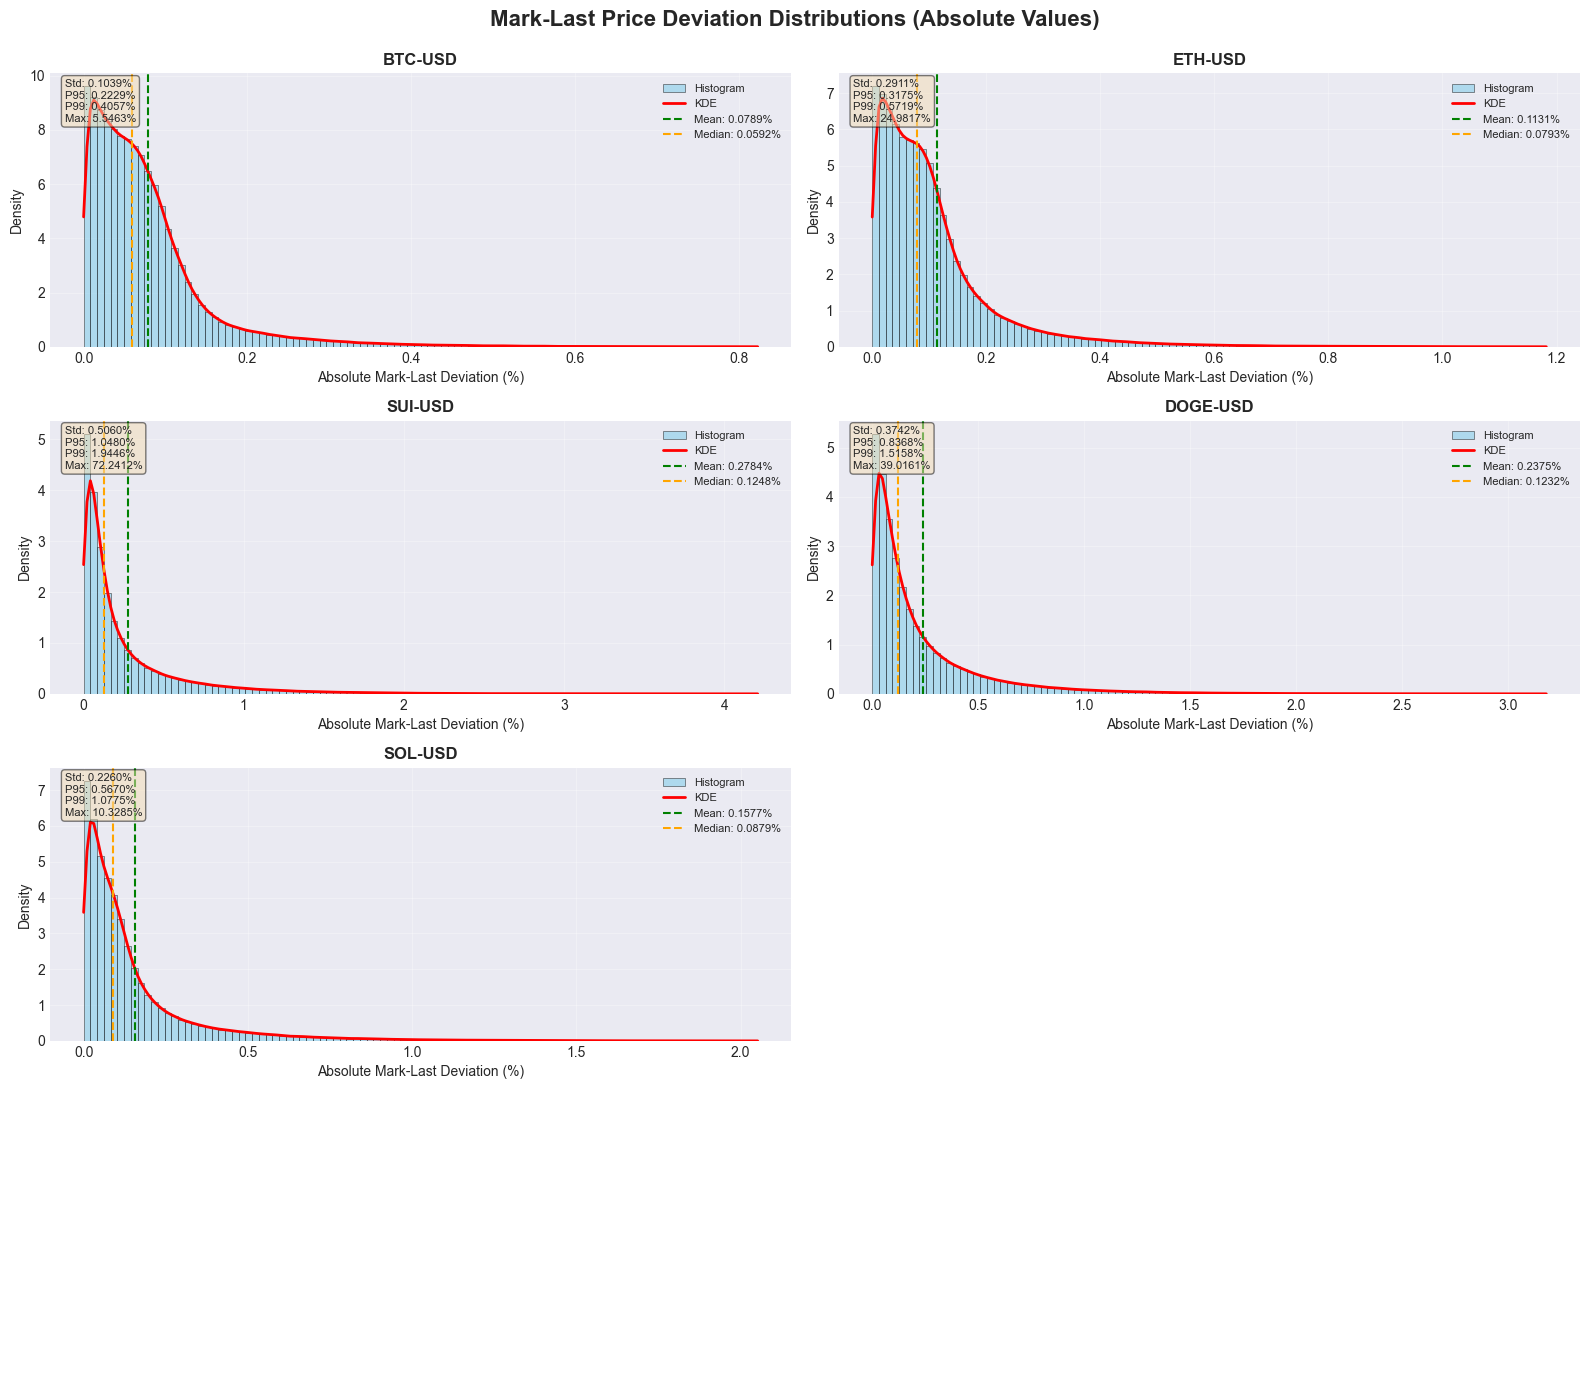

,Symbol,Mean (%),Median (%),Std Dev (%),Skewness,Kurtosis,Max (%)
0,BTC-USD,0.078874,0.059231,0.103909,13.5225,371.8018,5.5463
1,ETH-USD,0.113106,0.079261,0.291123,35.8706,1548.5850,24.9817
2,SUI-USD,0.278442,0.124850,0.505969,21.8943,1664.3749,72.2412
3,DOGE-USD,0.237531,0.123163,0.374229,14.8643,761.2336,39.0161
4,SOL-USD,0.157742,0.087932,0.225975,5.2431,71.0020,10.3285


In [7]:
# Plot distribution of Mark-Last deviations for all symbols (ABSOLUTE VALUES)
fig, axes = plt.subplots(4, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, symbol in enumerate(SYMBOLS):
    if symbol not in deviation_results:
        continue
    
    ax = axes[idx]
    df = deviation_results[symbol]
    
    # Use ABSOLUTE deviation values
    deviations_abs = df['mark_last_deviation'].abs().dropna()
    
    # Remove extreme outliers for better visualization (keep within 99.9th percentile)
    q999 = deviations_abs.quantile(0.999)
    deviations_trimmed = deviations_abs[deviations_abs <= q999]
    
    # Histogram
    ax.hist(deviations_trimmed, bins=100, alpha=0.6, color='skyblue', 
            edgecolor='black', linewidth=0.5, density=True, label='Histogram')
    
    # KDE overlay
    from scipy.stats import gaussian_kde
    if len(deviations_trimmed) > 1:
        kde = gaussian_kde(deviations_trimmed)
        x_range = np.linspace(deviations_trimmed.min(), deviations_trimmed.max(), 200)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    
    # Add vertical lines for mean and median
    mean_dev = deviations_abs.mean()
    median_dev = deviations_abs.median()
    ax.axvline(mean_dev, color='green', linestyle='--', linewidth=1.5, 
               label=f'Mean: {mean_dev:.4f}%')
    ax.axvline(median_dev, color='orange', linestyle='--', linewidth=1.5, 
               label=f'Median: {median_dev:.4f}%')
    
    # Statistics text box
    stats_text = (f"Std: {deviations_abs.std():.4f}%\n"
                  f"P95: {deviations_abs.quantile(0.95):.4f}%\n"
                  f"P99: {deviations_abs.quantile(0.99):.4f}%\n"
                  f"Max: {deviations_abs.max():.4f}%")
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=8,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Absolute Mark-Last Deviation (%)')
    ax.set_ylabel('Density')
    ax.set_title(f'{symbol}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide empty subplots if any
for idx in range(len(SYMBOLS), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Mark-Last Price Deviation Distributions (Absolute Values)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Create summary statistics table
from scipy.stats import skew, kurtosis

distribution_stats = []
for symbol in SYMBOLS:
    if symbol not in deviation_results:
        continue

    df = deviation_results[symbol]
    deviations = df['mark_last_deviation'].dropna()
    deviations_abs = deviations.abs()

    # Calculate skewness and kurtosis on absolute values
    skewness = skew(deviations_abs)
    kurt = kurtosis(deviations_abs)

    distribution_stats.append({
        'Symbol': symbol,
        'Mean (%)': deviations_abs.mean(),
        'Median (%)': deviations_abs.median(),
        'Std Dev (%)': deviations_abs.std(),
        'Skewness': skewness,
        'Kurtosis': kurt,
        'Max (%)': deviations_abs.max()
    })

distribution_df = pd.DataFrame(distribution_stats)
display(HTML('<h3 style="text-align: center; margin-top: 20px; margin-bottom: 10px; font-weight: bold;">DISTRIBUTION ANALYSIS (ABSOLUTE DEVIATIONS)</h3>'))
display(distribution_df.style.format({
    'Mean (%)': '{:.6f}',
    'Median (%)': '{:.6f}',
    'Std Dev (%)': '{:.6f}',
    'Skewness': '{:.4f}',
    'Kurtosis': '{:.4f}',
    'Max (%)': '{:.4f}'
}))


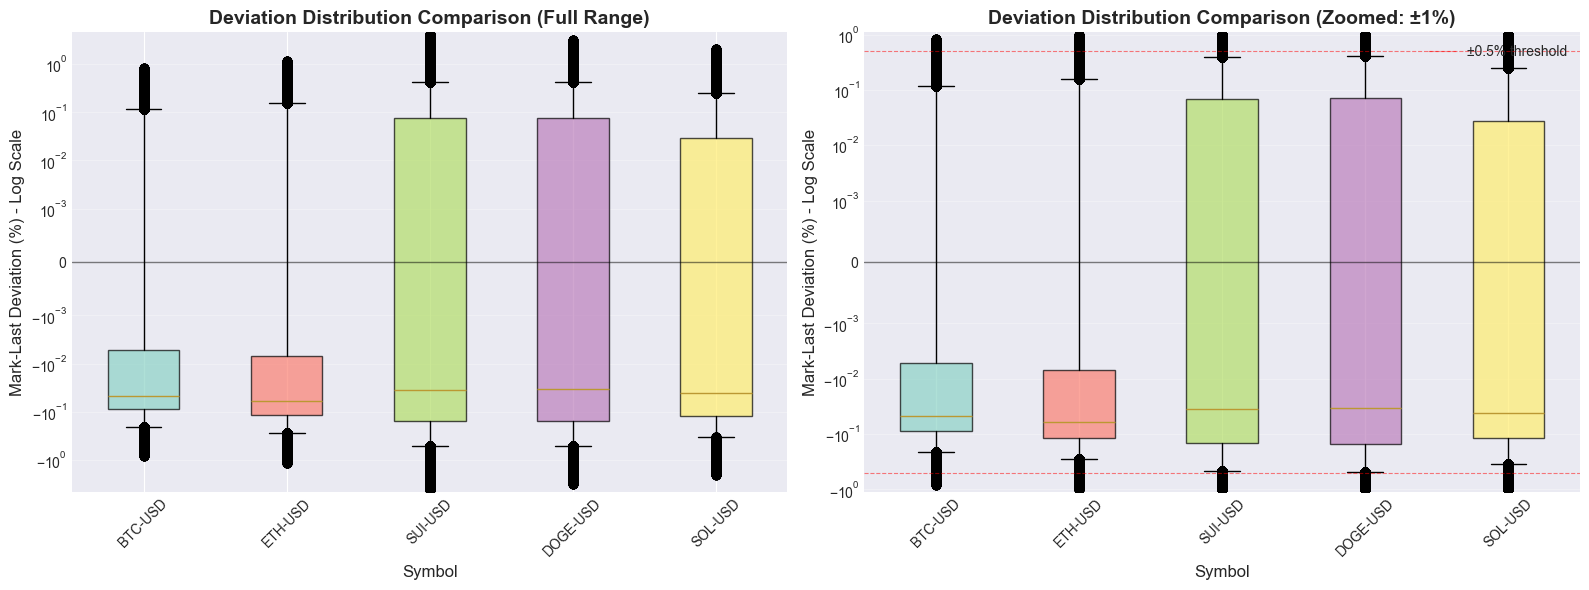

,Symbol,≤ 0.5%,0.5-1.0%,1.0-2.0%,2.0-5.0%,≥ 5.0%
0,BTC-USD,"581,818","2,405",114,302,1
1,ETH-USD,"575,825","7,937",560,25,293
2,SUI-USD,"491,052","61,433","26,844","4,951",360
3,DOGE-USD,"510,067","55,299","16,848","2,186",240
4,SOL-USD,"547,379","29,961","6,646",624,30


In [8]:
# Box plot comparison across all symbols
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data for box plots
deviation_data = []
symbol_labels = []

for symbol in SYMBOLS:
    if symbol not in deviation_results:
        continue

    df = deviation_results[symbol]
    deviations = df['mark_last_deviation'].dropna()

    # Trim extreme outliers for better visualization
    q999 = deviations.abs().quantile(0.999)
    deviations_trimmed = deviations[deviations.abs() <= q999]

    deviation_data.append(deviations_trimmed)
    symbol_labels.append(symbol)

# Box plot 1: Full range (trimmed to 99.9th percentile) with LOG SCALE
bp1 = ax1.boxplot(deviation_data, labels=symbol_labels, patch_artist=True,
                   showfliers=True, whis=1.5)

# Color the boxes
colors = plt.cm.Set3(np.linspace(0, 1, len(symbol_labels)))
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax1.set_xlabel('Symbol', fontsize=12)
ax1.set_ylabel('Mark-Last Deviation (%) - Log Scale', fontsize=12)
ax1.set_title('Deviation Distribution Comparison (Full Range)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)
# Set symmetric log scale (handles both positive and negative values)
ax1.set_yscale('symlog', linthresh=0.001)

# Box plot 2: Zoomed in to typical range (±1%) with LOG SCALE
deviation_data_zoom = []
for deviations in deviation_data:
    deviation_data_zoom.append(deviations[deviations.abs() <= 1.0])

bp2 = ax2.boxplot(deviation_data_zoom, labels=symbol_labels, patch_artist=True,
                   showfliers=True, whis=1.5)

# Color the boxes
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='±0.5% threshold')
ax2.axhline(y=-0.5, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.set_xlabel('Symbol', fontsize=12)
ax2.set_ylabel('Mark-Last Deviation (%) - Log Scale', fontsize=12)
ax2.set_title('Deviation Distribution Comparison (Zoomed: ±1%)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(loc='upper right')
# Set symmetric log scale (handles both positive and negative values)
ax2.set_yscale('symlog', linthresh=0.001)

plt.tight_layout()
plt.show()

# Calculate COUNTS of deviations in discrete buckets (not cumulative)
threshold_stats = []
for symbol in SYMBOLS:
    if symbol not in deviation_results:
        continue

    df = deviation_results[symbol]
    deviations = df['mark_last_deviation'].dropna()
    abs_dev = deviations.abs()

    # Discrete buckets:
    # 0.5%: abs(v) <= 0.5%
    # 1.0%: 0.5% < abs(v) <= 1.0%
    # 2.0%: 1.0% < abs(v) <= 2.0%
    # 5.0%: 2.0% < abs(v) < 5.0%
    # 5.0%+: abs(v) >= 5.0%
    count_0_to_05 = (abs_dev <= 0.5).sum()
    count_05_to_10 = ((abs_dev > 0.5) & (abs_dev <= 1.0)).sum()
    count_10_to_20 = ((abs_dev > 1.0) & (abs_dev <= 2.0)).sum()
    count_20_to_50 = ((abs_dev > 2.0) & (abs_dev < 5.0)).sum()
    count_beyond_50 = (abs_dev >= 5.0).sum()

    threshold_stats.append({
        'Symbol': symbol,
        '≤ 0.5%': count_0_to_05,
        '0.5-1.0%': count_05_to_10,
        '1.0-2.0%': count_10_to_20,
        '2.0-5.0%': count_20_to_50,
        '≥ 5.0%': count_beyond_50
    })

threshold_df = pd.DataFrame(threshold_stats)
display(HTML('<h3 style="text-align: center; margin-top: 20px; margin-bottom: 10px; font-weight: bold;">DEVIATION THRESHOLD ANALYSIS</h3>'))
display(threshold_df.style.format({
    '≤ 0.5%': '{:,.0f}',
    '0.5-1.0%': '{:,.0f}',
    '1.0-2.0%': '{:,.0f}',
    '2.0-5.0%': '{:,.0f}',
    '≥ 5.0%': '{:,.0f}'
}))

### 3.1. Simple Model: Fixed Bandwidth Price Bands

The Simple Model uses a constant percentage bandwidth around the Mark Price, similar to Paradex and GRVT implementations:

$$\text{UpperBand}_t = \text{MarkPrice}_t \times (1 + \text{BW})$$
$$\text{LowerBand}_t = \text{MarkPrice}_t \times (1 - \text{BW})$$

Where $\text{BW}$ is the fixed bandwidth parameter (e.g., 0.01 = 1%).

The bands define acceptable ranges for Last Price relative to Mark Price. If Last Price falls outside these bands, it signals potential oracle manipulation or market dysfunction.

**Advantages**:
- Simple to implement and explain
- Consistent behavior across market conditions
- Transparent to users

**Disadvantages**:
- Doesn't adapt to volatility changes
- May be too tight during high volatility (false positives)
- May be too wide during low volatility (false negatives)

We use regression to find the optimal $\text{BW}$ that minimizes false positives while maintaining adequate protection.

In [9]:
def calculate_simple_price_bands(df: pd.DataFrame, bandwidth: float = 0.01) -> pd.DataFrame:
    """
    Calculate simple fixed-bandwidth price bands around Mark Price.
    
    Args:
        df: DataFrame with mark_price and last_price columns
        bandwidth: Fixed bandwidth as decimal (e.g., 0.01 = 1%)
    
    Returns:
        DataFrame with simple price bands added
    """
    result = df.copy()
    
    # Calculate bands around Mark Price
    result['simple_upper_band'] = result['mark_price'] * (1 + bandwidth)
    result['simple_lower_band'] = result['mark_price'] * (1 - bandwidth)
    
    # Check for breaches (Last Price outside bands)
    result['simple_breach_upper'] = result['last_price'] > result['simple_upper_band']
    result['simple_breach_lower'] = result['last_price'] < result['simple_lower_band']
    result['simple_breach'] = result['simple_breach_upper'] | result['simple_breach_lower']
    
    # Calculate breach magnitude (how far Last Price is outside band, as % of Mark Price)
    result['simple_breach_magnitude'] = np.where(
        result['simple_breach_upper'],
        (result['last_price'] - result['simple_upper_band']) / result['mark_price'] * 100,
        np.where(
            result['simple_breach_lower'],
            (result['simple_lower_band'] - result['last_price']) / result['mark_price'] * 100,
            0
        )
    )
    
    return result

def regress_optimal_bandwidth(df: pd.DataFrame, target_breach_rate: float = 0.01) -> dict:
    """
    Find optimal bandwidth that achieves target breach rate.
    
    Args:
        df: DataFrame with mark_last_deviation column
        target_breach_rate: Target breach rate (default 1% = 0.01)
    
    Returns:
        Dictionary with optimal bandwidth and statistics
    """
    # Use percentile of absolute deviations as bandwidth estimate
    abs_deviations = df['mark_last_deviation'].abs().dropna()
    
    # Find percentile that corresponds to target breach rate
    # If we want 1% breach rate, we need 99th percentile
    percentile = (1 - target_breach_rate) * 100
    optimal_bw = np.percentile(abs_deviations, percentile) / 100  # Convert to decimal
    
    # Test this bandwidth
    test_df = calculate_simple_price_bands(df, optimal_bw)
    actual_breach_rate = test_df['simple_breach'].sum() / len(test_df)
    
    # Calculate max deviation
    max_deviation = abs_deviations.max()
    
    return {
        'optimal_bandwidth': optimal_bw,
        'optimal_bandwidth_pct': optimal_bw * 100,
        'target_breach_rate': target_breach_rate,
        'actual_breach_rate': actual_breach_rate,
        'max_deviation_pct': max_deviation,
        'p95_deviation_pct': np.percentile(abs_deviations, 95),
        'p99_deviation_pct': np.percentile(abs_deviations, 99)
    }

print("Simple price band functions defined")

Simple price band functions defined


In [10]:
# Regress optimal bandwidth for Simple Model
simple_regression_results = {}

print("=" * 70)
print("SIMPLE MODEL: Bandwidth Regression")
print("=" * 70)
print(f"\nTarget Breach Rate: 1.0%\n")

for symbol in SYMBOLS:
    if symbol not in deviation_results:
        continue
    
    df = deviation_results[symbol].copy()
    
    # Regress optimal bandwidth
    results = regress_optimal_bandwidth(df, target_breach_rate=0.01)
    simple_regression_results[symbol] = results

print(f"Completed bandwidth regression for {len(simple_regression_results)} symbols\n")

# Create beautiful table display
from IPython.display import HTML, display

simple_table_data = []
for symbol in SYMBOLS:
    if symbol not in simple_regression_results:
        continue
    
    results = simple_regression_results[symbol]
    simple_table_data.append({
        'Symbol': symbol,
        'Optimal Bandwidth (%)': results['optimal_bandwidth_pct'],
        'Actual Breach Rate (%)': results['actual_breach_rate'] * 100,
        'Max Deviation (%)': results['max_deviation_pct'],
        'P95 Deviation (%)': results['p95_deviation_pct'],
        'P99 Deviation (%)': results['p99_deviation_pct']
    })

simple_table_df = pd.DataFrame(simple_table_data)

display(HTML('<h2 style="text-align: center; margin-top: 30px; margin-bottom: 15px; font-weight: bold; color: #2c3e50;">SIMPLE MODEL: BANDWIDTH REGRESSION RESULTS</h2>'))
display(HTML('<h3 style="text-align: center; margin-top: 10px; margin-bottom: 15px; font-weight: normal; color: #7f8c8d;">Target Breach Rate: 1.0%</h3>'))

display(simple_table_df.style.format({
    'Optimal Bandwidth (%)': '{:.4f}',
    'Actual Breach Rate (%)': '{:.4f}',
    'Max Deviation (%)': '{:.4f}',
    'P95 Deviation (%)': '{:.4f}',
    'P99 Deviation (%)': '{:.4f}'
}).set_properties(**{
    'text-align': 'center',
    'font-size': '11pt'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#e74c3c'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '10px')]},
    {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '8px')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
]).hide(axis='index'))

SIMPLE MODEL: Bandwidth Regression

Target Breach Rate: 1.0%

Completed bandwidth regression for 5 symbols



Symbol,Optimal Bandwidth (%),Actual Breach Rate (%),Max Deviation (%),P95 Deviation (%),P99 Deviation (%)
BTC-USD,0.4057,1.0052,5.5463,0.2229,0.4057
ETH-USD,0.5719,1.0059,24.9817,0.3175,0.5719
SUI-USD,1.9446,1.0069,72.2412,1.0480,1.9446
DOGE-USD,1.5158,1.0071,39.0161,0.8368,1.5158
SOL-USD,1.0775,1.0049,10.3285,0.5670,1.0775


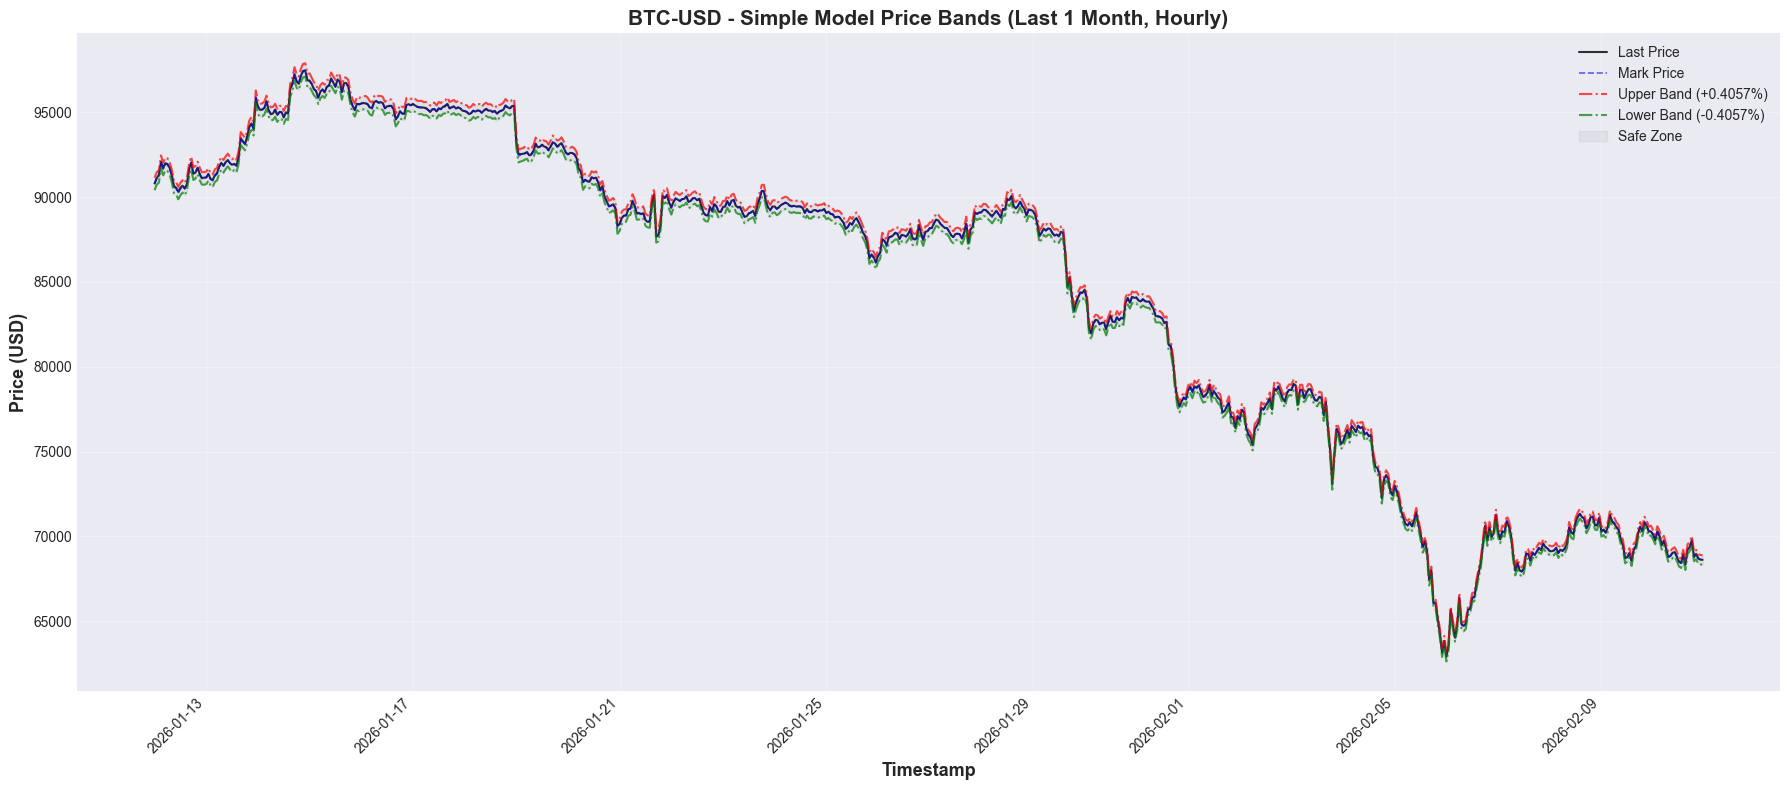


BTC-USD Statistics:
  Optimal Bandwidth: 0.4057%
  Total Data Points: 584,640
  Breach Count: 5,877
  Breach Rate: 1.0052%
  Visualization Period: 2026-01-12 00:00:00+00:00 to 2026-02-10 23:00:00+00:00



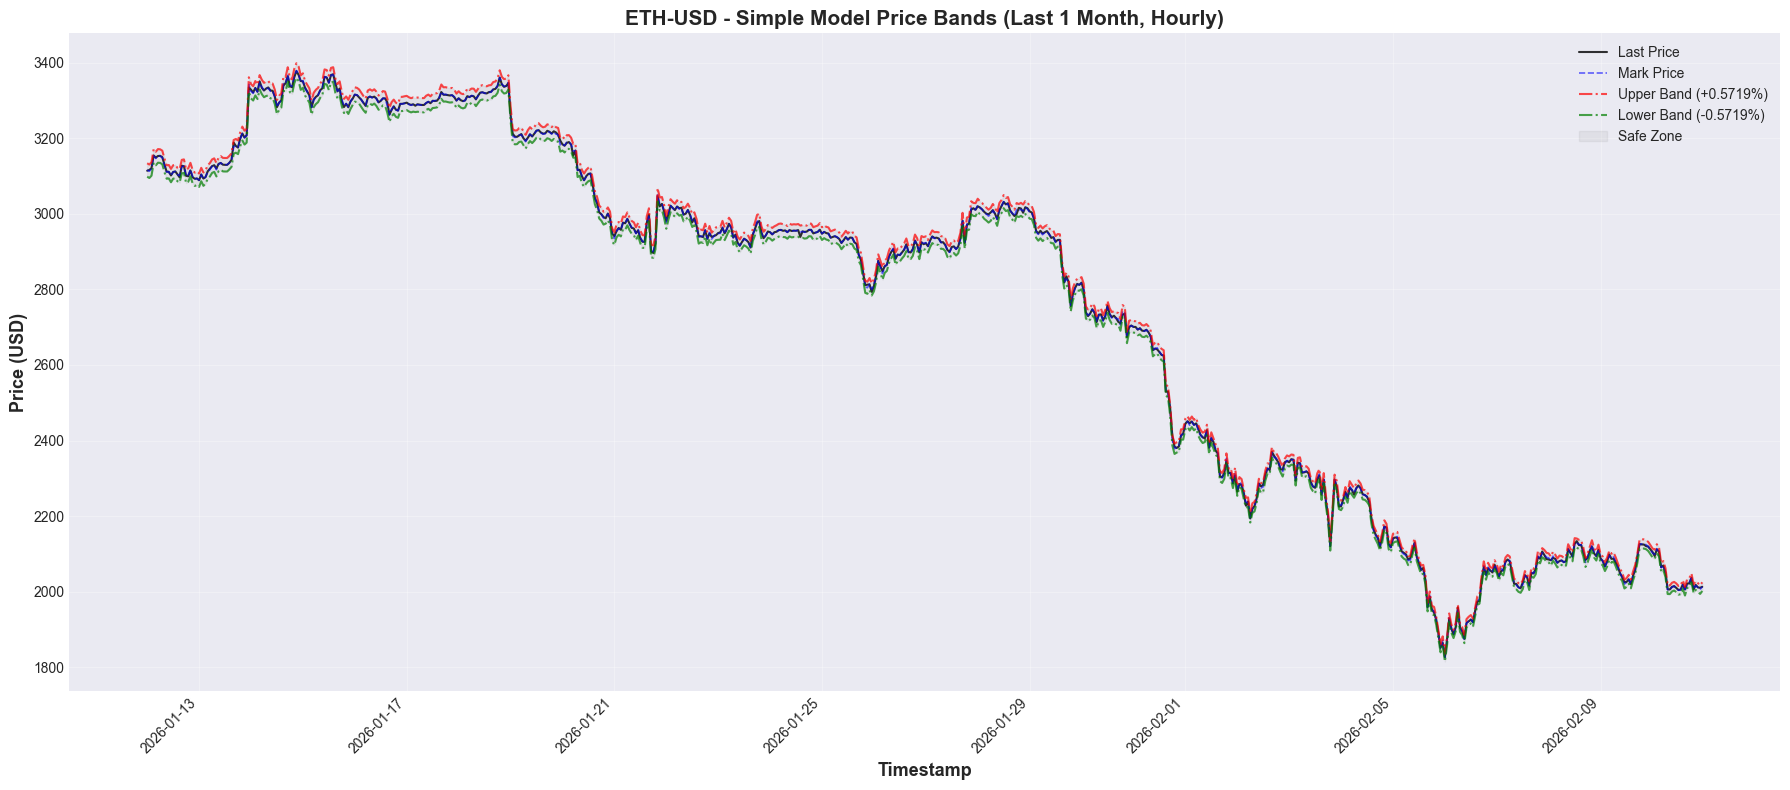


ETH-USD Statistics:
  Optimal Bandwidth: 0.5719%
  Total Data Points: 584,640
  Breach Count: 5,881
  Breach Rate: 1.0059%
  Visualization Period: 2026-01-12 00:00:00+00:00 to 2026-02-10 23:00:00+00:00



In [11]:
# Visualize Simple Price Bands for BTC and ETH

# Focus on BTC and ETH
viz_symbols = ['BTC-USD', 'ETH-USD']

for symbol in viz_symbols:
    if symbol not in deviation_results or symbol not in simple_regression_results:
        continue
    
    # Get data and calculate bands with optimal bandwidth
    df = deviation_results[symbol].copy()
    bandwidth = simple_regression_results[symbol]['optimal_bandwidth']
    
    # Calculate simple bands
    df_bands = calculate_simple_price_bands(df, bandwidth=bandwidth)
    
    # Sample data for better visualization (every 60 minutes = 1 hour)
    # For ~1 year of data at 1-min intervals, we have ~500K records
    # Sample every 60 minutes to get ~8K points
    df_sample = df_bands.iloc[::60].copy()
    
    # Further limit to recent 1 month for clarity
    df_recent = df_sample.tail(720)  # 1 month * 30 days * 24 hours
    
    # Create figure
    fig, ax = plt.subplots(figsize=(18, 8))
    
    # Plot last price
    ax.plot(df_recent.index, df_recent['last_price'], 
            label='Last Price', color='black', linewidth=1.5, alpha=0.8)
    
    # Plot mark price for reference
    ax.plot(df_recent.index, df_recent['mark_price'], 
            label='Mark Price', color='blue', linewidth=1.2, alpha=0.6, linestyle='--')
    
    # Plot bands
    ax.plot(df_recent.index, df_recent['simple_upper_band'], 
            label=f'Upper Band (+{bandwidth*100:.4f}%)', 
            color='red', linewidth=1.5, alpha=0.7, linestyle='-.')
    ax.plot(df_recent.index, df_recent['simple_lower_band'], 
            label=f'Lower Band (-{bandwidth*100:.4f}%)', 
            color='green', linewidth=1.5, alpha=0.7, linestyle='-.')
    
    # Fill between bands for visual clarity
    ax.fill_between(df_recent.index, 
                     df_recent['simple_lower_band'], 
                     df_recent['simple_upper_band'],
                     alpha=0.1, color='gray', label='Safe Zone')
    
    # Highlight breach zones (where last_price is outside bands)
    breaches = df_recent[df_recent['simple_breach']]
    if len(breaches) > 0:
        ax.scatter(breaches.index, breaches['last_price'], 
                  color='red', s=30, alpha=0.6, zorder=5, 
                  label=f'Breaches ({len(breaches)} events)')
    
    # Formatting
    ax.set_xlabel('Timestamp', fontsize=13, fontweight='bold')
    ax.set_ylabel('Price (USD)', fontsize=13, fontweight='bold')
    ax.set_title(f'{symbol} - Simple Model Price Bands (Last 1 Month, Hourly)', 
                 fontsize=15, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    breach_count = df_bands['simple_breach'].sum()
    breach_rate = (breach_count / len(df_bands)) * 100
    print(f"\n{symbol} Statistics:")
    print(f"  Optimal Bandwidth: {bandwidth*100:.4f}%")
    print(f"  Total Data Points: {len(df_bands):,}")
    print(f"  Breach Count: {breach_count:,}")
    print(f"  Breach Rate: {breach_rate:.4f}%")
    print(f"  Visualization Period: {df_recent.index[0]} to {df_recent.index[-1]}")
    print()


### 3.2. Complex Model: EWMA Volatility-Based Dynamic Bands

The Complex Model adapts the band width to recent volatility using an Exponentially Weighted Moving Average (EWMA). The EWMA volatility estimate reacts quickly to volatility regime changes while maintaining smoothness.

$$\sigma^2_{\text{EWMA},t} = \lambda \times \sigma^2_{\text{EWMA},t-1} + (1 - \lambda) \times r^2_t$$

Where:
- $\lambda$ is the decay factor (typically $0.94 - 0.99$)
- $\sigma^2_{\text{EWMA},t-1}$ is the previous variance estimate
- $r^2_t$ is the current squared return (using Parkinson range-based estimate)

For Price Band application, we use $\lambda = 0.96$ providing 1-2 hour effective memory, balancing responsiveness and stability.

### Dynamic Band Calculation

The Price Band upper and lower limits are calculated as:

$$\text{UpperBand}_t = \text{LastPrice}_t \times (1 + k \times \sigma_{\text{EWMA},t})$$
$$\text{LowerBand}_t = \text{LastPrice}_t \times (1 - k \times \sigma_{\text{EWMA},t})$$

Where $k$ is the band width multiplier (number of standard deviations), typically $2.0 - 3.0$.

**Choice of k**:
- $k = 2.0$: ~5% false alarms (assuming normal distribution)
- $k = 2.5$: ~1% false alarms (recommended for risk-critical applications)
- $k = 3.0$: ~0.3% false alarms (very conservative)

We use regression to find the optimal $k$ multiplier for each asset.

In [12]:
def calculate_parkinson_variance(df: pd.DataFrame) -> pd.Series:
    """
    Calculate Parkinson variance estimator from OHLC data.
    
    Formula: σ² = (1/(4·ln(2))) · (ln(H/L))²
    
    Args:
        df: DataFrame with 'high' and 'low' columns
    
    Returns:
        Series with Parkinson variance estimates
    """
    hl_ratio = np.log(df['high'] / df['low'])
    parkinson_var = (1 / (4 * np.log(2))) * (hl_ratio ** 2)
    
    return parkinson_var

def calculate_ewma_volatility(df: pd.DataFrame, lambda_decay: float = 0.96, 
                             init_window: int = 60) -> pd.Series:
    """
    Calculate EWMA volatility using Parkinson estimator.
    
    Args:
        df: DataFrame with OHLC data
        lambda_decay: Decay factor (0.94 - 0.99)
        init_window: Window for initial variance estimate
    
    Returns:
        Series with EWMA volatility (standard deviation)
    """
    # Calculate Parkinson variance for each period
    parkinson_var = calculate_parkinson_variance(df)
    
    # Initialize EWMA with rolling average
    initial_var = parkinson_var.rolling(init_window).mean()
    
    # Calculate EWMA variance
    ewma_var = parkinson_var.ewm(alpha=1-lambda_decay, adjust=False).mean()
    
    # Use initial variance for warmup period
    ewma_var = ewma_var.fillna(initial_var)
    
    # Return standard deviation (not variance)
    return np.sqrt(ewma_var)

def calculate_dynamic_price_bands(df: pd.DataFrame, k: float = 2.5, lambda_decay: float = 0.96) -> pd.DataFrame:
    """
    Calculate dynamic price bands using EWMA volatility.
    
    Args:
        df: DataFrame with OHLC and price data
        k: Band width multiplier (number of standard deviations)
        lambda_decay: EWMA decay factor
    
    Returns:
        DataFrame with price bands and breach indicators
    """
    result = df.copy()
    
    # Calculate EWMA volatility from Last Price OHLC
    ewma_vol = calculate_ewma_volatility(df, lambda_decay=lambda_decay)
    result['ewma_volatility'] = ewma_vol
    
    # Calculate bands around Last Price
    result['dynamic_upper_band'] = result['last_price'] * (1 + k * ewma_vol)
    result['dynamic_lower_band'] = result['last_price'] * (1 - k * ewma_vol)
    
    # Check for breaches (Mark Price outside bands)
    result['dynamic_breach_upper'] = result['mark_price'] > result['dynamic_upper_band']
    result['dynamic_breach_lower'] = result['mark_price'] < result['dynamic_lower_band']
    result['dynamic_breach'] = result['dynamic_breach_upper'] | result['dynamic_breach_lower']
    
    # Calculate breach magnitude (how far outside band)
    result['dynamic_breach_magnitude'] = np.where(
        result['dynamic_breach_upper'],
        (result['mark_price'] - result['dynamic_upper_band']) / result['last_price'] * 100,
        np.where(
            result['dynamic_breach_lower'],
            (result['dynamic_lower_band'] - result['mark_price']) / result['last_price'] * 100,
            0
        )
    )
    
    return result

def regress_optimal_k(df: pd.DataFrame, lambda_decay: float = 0.96, target_breach_rate: float = 0.01) -> dict:
    """
    Find optimal k multiplier that achieves target breach rate.
    
    Args:
        df: DataFrame with OHLC and mark/last prices
        lambda_decay: EWMA decay parameter
        target_breach_rate: Target breach rate (default 1% = 0.01)
    
    Returns:
        Dictionary with optimal k and statistics
    """
    # Test multiple k values
    k_values = np.linspace(1.0, 5.0, 50)
    breach_rates = []
    
    for k in k_values:
        test_df = calculate_dynamic_price_bands(df, k=k, lambda_decay=lambda_decay)
        breach_rate = test_df['dynamic_breach'].sum() / len(test_df)
        breach_rates.append(breach_rate)
    
    # Find k closest to target breach rate
    breach_rates = np.array(breach_rates)
    idx = np.argmin(np.abs(breach_rates - target_breach_rate))
    optimal_k = k_values[idx]
    actual_breach_rate = breach_rates[idx]
    
    # Calculate statistics with optimal k
    final_df = calculate_dynamic_price_bands(df, k=optimal_k, lambda_decay=lambda_decay)
    
    abs_deviations = df['mark_last_deviation'].abs().dropna()
    ewma_vol = final_df['ewma_volatility'].dropna()
    
    return {
        'optimal_k': optimal_k,
        'lambda_decay': lambda_decay,
        'target_breach_rate': target_breach_rate,
        'actual_breach_rate': actual_breach_rate,
        'max_deviation_pct': abs_deviations.max(),
        'p95_deviation_pct': np.percentile(abs_deviations, 95),
        'p99_deviation_pct': np.percentile(abs_deviations, 99),
        'ewma_vol_mean_pct': ewma_vol.mean() * 100,
        'ewma_vol_std_pct': ewma_vol.std() * 100,
        'ewma_vol_max_pct': ewma_vol.max() * 100
    }

print("Dynamic EWMA price band functions defined")

Dynamic EWMA price band functions defined


In [13]:
# Regress optimal k multiplier for Complex Model
dynamic_regression_results = {}
all_band_results = {}

print("=" * 70)
print("COMPLEX MODEL: k Multiplier Regression (λ = 0.96)")
print("=" * 70)
print(f"\nTarget Breach Rate: 1.0%\n")

for symbol in SYMBOLS:
    if symbol not in deviation_results:
        continue
    
    # Get deviation data with OHLC
    dev_df = deviation_results[symbol].copy()
    trades_df = trades_data[symbol]  # Changed from klines_data to trades_data
    
    # Add OHLC for volatility calculation
    dev_df['open'] = trades_df['open']
    dev_df['high'] = trades_df['high']
    dev_df['low'] = trades_df['low']
    dev_df['close'] = trades_df['close']
    
    # Regress optimal k
    results = regress_optimal_k(dev_df, lambda_decay=0.96, target_breach_rate=0.01)
    dynamic_regression_results[symbol] = results
    
    # Calculate bands with optimal k for later use
    final_bands = calculate_dynamic_price_bands(dev_df, k=results['optimal_k'], lambda_decay=0.96)
    
    # Also calculate simple bands with optimal bandwidth
    simple_results = simple_regression_results[symbol]
    final_bands = calculate_simple_price_bands(final_bands, bandwidth=simple_results['optimal_bandwidth'])
    
    all_band_results[symbol] = final_bands

print(f"Completed k multiplier regression for {len(dynamic_regression_results)} symbols\n")

# Create beautiful table display
from IPython.display import HTML, display

dynamic_table_data = []
for symbol in SYMBOLS:
    if symbol not in dynamic_regression_results:
        continue
    
    results = dynamic_regression_results[symbol]
    dynamic_table_data.append({
        'Symbol': symbol,
        'Optimal k': results['optimal_k'],
        'Lambda (λ)': results['lambda_decay'],
        'Actual Breach Rate (%)': results['actual_breach_rate'] * 100,
        'EWMA Vol Mean (%)': results['ewma_vol_mean_pct'],
        'EWMA Vol Std (%)': results['ewma_vol_std_pct'],
        'EWMA Vol Max (%)': results['ewma_vol_max_pct'],
        'Max Deviation (%)': results['max_deviation_pct'],
        'P95 Deviation (%)': results['p95_deviation_pct'],
        'P99 Deviation (%)': results['p99_deviation_pct']
    })

dynamic_table_df = pd.DataFrame(dynamic_table_data)

display(HTML('<h2 style="text-align: center; margin-top: 30px; margin-bottom: 15px; font-weight: bold; color: #2c3e50;">COMPLEX MODEL: k MULTIPLIER REGRESSION RESULTS</h2>'))
display(HTML('<h3 style="text-align: center; margin-top: 10px; margin-bottom: 15px; font-weight: normal; color: #7f8c8d;">Target Breach Rate: 1.0% | Lambda (λ) = 0.96</h3>'))

display(dynamic_table_df.style.format({
    'Optimal k': '{:.4f}',
    'Lambda (λ)': '{:.2f}',
    'Actual Breach Rate (%)': '{:.4f}',
    'EWMA Vol Mean (%)': '{:.4f}',
    'EWMA Vol Std (%)': '{:.4f}',
    'EWMA Vol Max (%)': '{:.4f}',
    'Max Deviation (%)': '{:.4f}',
    'P95 Deviation (%)': '{:.4f}',
    'P99 Deviation (%)': '{:.4f}'
}).set_properties(**{
    'text-align': 'center',
    'font-size': '11pt'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#2ecc71'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '10px')]},
    {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '8px')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
]).hide(axis='index'))

COMPLEX MODEL: k Multiplier Regression (λ = 0.96)

Target Breach Rate: 1.0%

Completed k multiplier regression for 5 symbols



Symbol,Optimal k,Lambda (λ),Actual Breach Rate (%),EWMA Vol Mean (%),EWMA Vol Std (%),EWMA Vol Max (%),Max Deviation (%),P95 Deviation (%),P99 Deviation (%)
BTC-USD,5.0000,0.96,18.8555,0.0354,0.0319,1.5853,5.5463,0.2229,0.4057
ETH-USD,5.0000,0.96,11.7394,0.0604,0.0485,1.7733,24.9817,0.3175,0.5719
SUI-USD,5.0000,0.96,26.7255,0.0792,0.1005,10.5494,72.2412,1.0480,1.9446
DOGE-USD,5.0000,0.96,29.5269,0.0677,0.1087,9.9404,39.0161,0.8368,1.5158
SOL-USD,5.0000,0.96,17.3529,0.0668,0.0552,2.9128,10.3285,0.5670,1.0775


## 4. Model Comparison and Summary Statistics

### Comprehensive Metrics

In [14]:
from IPython.display import HTML, display

# Generate comprehensive summary table
summary_data = []

for symbol in SYMBOLS:
    if symbol not in all_band_results:
        continue
    
    df = all_band_results[symbol]
    abs_dev = df['mark_last_deviation'].abs().dropna()
    
    # Simple model results
    simple_res = simple_regression_results[symbol]
    
    # Dynamic model results
    dynamic_res = dynamic_regression_results[symbol]
    
    # Calculate breach statistics
    simple_breaches = df['simple_breach'].sum()
    simple_breach_rate = (simple_breaches / len(df)) * 100
    
    dynamic_breaches = df['dynamic_breach'].sum()
    dynamic_breach_rate = (dynamic_breaches / len(df)) * 100
    
    summary_data.append({
        'Symbol': symbol,
        'Min (%)': abs_dev.min(),
        'Mean (%)': abs_dev.mean(),
        'Median (%)': abs_dev.median(),
        'P95 (%)': np.percentile(abs_dev, 95),
        'P99 (%)': np.percentile(abs_dev, 99),
        'Max (%)': abs_dev.max(),
        'Optimal Bandwidth (%)': simple_res['optimal_bandwidth_pct'],
        'Simple Achieved Breach Rate (%)': simple_breach_rate,
        'k Multiplier': dynamic_res['optimal_k'],
        'Lambda (λ)': dynamic_res['lambda_decay'],
        'Dynamic Achieved Breach Rate (%)': dynamic_breach_rate,
        'Mean EWMA Vol (%)': dynamic_res['ewma_vol_mean_pct']
    })

summary_df = pd.DataFrame(summary_data)

# Display beautiful formatted table
display(HTML('<h2 style="text-align: center; margin-top: 30px; margin-bottom: 15px; font-weight: bold; color: #2c3e50;">PRICE BAND ANALYSIS SUMMARY</h2>'))

display(HTML('<h3 style="text-align: center; margin-top: 20px; margin-bottom: 10px; font-weight: bold; color: #34495e;">Mark-Last Deviation Statistics (Absolute)</h3>'))
display(summary_df[['Symbol', 'Min (%)', 'Mean (%)', 'Median (%)', 'P95 (%)', 'P99 (%)', 'Max (%)']].style.format({
    'Min (%)': '{:.6f}',
    'Mean (%)': '{:.6f}',
    'Median (%)': '{:.6f}',
    'P95 (%)': '{:.6f}',
    'P99 (%)': '{:.6f}',
    'Max (%)': '{:.6f}'
}).set_properties(**{
    'text-align': 'center',
    'font-size': '11pt'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#3498db'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]))

display(HTML('<h3 style="text-align: center; margin-top: 20px; margin-bottom: 10px; font-weight: bold; color: #34495e;">Simple Model (Fixed Bandwidth)</h3>'))
display(summary_df[['Symbol', 'Optimal Bandwidth (%)', 'Simple Achieved Breach Rate (%)']].style.format({
    'Optimal Bandwidth (%)': '{:.4f}',
    'Simple Achieved Breach Rate (%)': '{:.4f}'
}).set_properties(**{
    'text-align': 'center',
    'font-size': '11pt'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#e74c3c'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]))

display(HTML('<h3 style="text-align: center; margin-top: 20px; margin-bottom: 10px; font-weight: bold; color: #34495e;">Complex Model (Dynamic EWMA)</h3>'))
display(summary_df[['Symbol', 'k Multiplier', 'Lambda (λ)', 'Dynamic Achieved Breach Rate (%)', 'Mean EWMA Vol (%)']].style.format({
    'k Multiplier': '{:.4f}',
    'Lambda (λ)': '{:.2f}',
    'Dynamic Achieved Breach Rate (%)': '{:.4f}',
    'Mean EWMA Vol (%)': '{:.4f}'
}).set_properties(**{
    'text-align': 'center',
    'font-size': '11pt'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#2ecc71'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]))

,Symbol,Min (%),Mean (%),Median (%),P95 (%),P99 (%),Max (%)
0,BTC-USD,0.000000,0.078874,0.059231,0.222910,0.405710,5.546261
1,ETH-USD,0.000000,0.113106,0.079261,0.317547,0.571943,24.981702
2,SUI-USD,0.000000,0.278442,0.124850,1.047980,1.944585,72.241248
3,DOGE-USD,0.000000,0.237531,0.123163,0.836841,1.515782,39.016138
4,SOL-USD,0.000000,0.157742,0.087932,0.566978,1.077543,10.328505


,Symbol,Optimal Bandwidth (%),Simple Achieved Breach Rate (%)
0,BTC-USD,0.4057,1.0052
1,ETH-USD,0.5719,1.0059
2,SUI-USD,1.9446,1.0069
3,DOGE-USD,1.5158,1.0071
4,SOL-USD,1.0775,1.0049


,Symbol,k Multiplier,Lambda (λ),Dynamic Achieved Breach Rate (%),Mean EWMA Vol (%)
0,BTC-USD,5.0000,0.96,18.8555,0.0354
1,ETH-USD,5.0000,0.96,11.7394,0.0604
2,SUI-USD,5.0000,0.96,26.7255,0.0792
3,DOGE-USD,5.0000,0.96,29.5269,0.0677
4,SOL-USD,5.0000,0.96,17.3529,0.0668
